# Gene Ontology (GO) Enrichment Analysis

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap
from matplotlib.colors import Normalize, to_hex

from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from genes_ncbi_proteincoding_all_homo_sapiens import GENEID2NT as GeneID2nt_bmmc

In [2]:
### Initialize Data for Go Analysis

# download: go-basic.obo; gene2go.gz; gene2go
# go-basic.obo: structured file describing Gene Ontology terms
# gene2go.gz: mapping between genes and their GO annotations
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

# Parsed into a structure (obodag) for further analysis
obodag = GODag("go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms


In [3]:
# Create a dictionary with keys: gene symbols and values: corresponding NCBI Gene ID for downloaded human genes
mapper = {}

for key in GeneID2nt_bmmc:
    mapper[GeneID2nt_bmmc[key].Symbol] = GeneID2nt_bmmc[key].GeneID

# Create inverse dictionary 
inv_map = {v: k for k, v in mapper.items()}

In [5]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
# Gene2GoReader loads the gene-to-GO annotations from gene2go.gz
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
# Get the namespace-to-association dictionary
ns2assoc = objanno.get_ns2assc()

HMS:0:01:07.429770 362,439 annotations, 20,832 genes, 18,691 GOs, 1 taxids READ: gene2go 


In [6]:
# Set up GOEnrichmentStudyNS analysis object 

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_bmmc.keys(), # List of library genes
        ns2assoc, # Gene ID / GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # Default significance cut-off
        methods = ['fdr_bh']) # Default multiple test correction method


Load BP Ontology Enrichment Analysis ...
 83% 17,079 of 20,597 population items found in association

Load CC Ontology Enrichment Analysis ...
 89% 18,232 of 20,597 population items found in association

Load MF Ontology Enrichment Analysis ...
 87% 17,822 of 20,597 population items found in association


In [7]:
# Extracts all GO terms from BP, CC, and MF categories into GO_items

GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

In [9]:
#  Define function for GO analysis

def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene]) # Converts into NCBI Gene IDs using the mapper
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes) # Runs GO enrichment analysis on the mapped genes.
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05] # Filters for significant GO terms
    
    # Save as DataFrame 
    
    # GO ID (GO)
    # Description (term)
    # Category (class)
    # Raw p-value (p)
    # Corrected p-value (p_corr)
    # Number of genes associated with this GO term (n_genes)
    # Total number of genes in study (n_study)
    # How often this GO term appears (n_go)
    # List of involved genes (study_genes)
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])
    
    GO = GO[GO.n_genes > 1]
    return GO

In [11]:
# Load Genes Correlated with Embedding Dimensions

cor_genes = pd.read_csv("/Users/olyssa/PycharmProjects/VAE_embeddings/1_Gene_module_encoding_analysis/1a_correlation_analysis/corals_spearman_pvalues_results.csv")
all_top_genes = cor_genes[(cor_genes["P_Value"]<= 0.001 ) & (np.abs(cor_genes["Spearman_Correlation"]) >= 0.3 )]
all_top_genes = all_top_genes

In [13]:
# Perform GO analysis

Go_dim = [] # List to collect all dimensions for which go analysis was possible
go_results = {} # Dictionary to collect all go_dim dataframes

# Loop over all dimensions with >= 15 correlated genes 
for i in range(len(all_top_genes["Embedding_Feature"].unique())):
    top_genes = all_top_genes[all_top_genes["Embedding_Feature"] == i]["Gene"].values  # Werte als NumPy-Array extrahieren
    print (f"STARTING WITH DIM {i}\n",f"Top genes of Dim {i}:", top_genes) 
    if len(top_genes) >= 15: 
        Go_analysis = go_it(top_genes)
        Go_analysis['per'] = Go_analysis.n_genes/Go_analysis.n_go
        go_results[i] = Go_analysis
        Go_dim.append(i)
        Go_analysis

STARTING WITH DIM 0
 Top genes of Dim 0: ['MALAT1']
STARTING WITH DIM 1
 Top genes of Dim 1: ['ROR1' 'FCRL1' 'RALGPS2' 'AFF3' 'ADAM23' 'ARPP21' 'CCDC191' 'MME' 'BANK1'
 'CAMK2D' 'EBF1' 'KHDRBS2' 'COL19A1' 'BACH2' 'PLEKHG1' 'RAPGEF5' 'PAX5'
 'ZCCHC7' 'MS4A1' 'DTX1' 'RUBCNL' 'PCDH9' 'ACSM3' 'CD79B' 'KLHL14'
 'NIBAN3' 'SLC9A7']
input genes: 27
mapped genes: 27

Runing BP Ontology Analysis: current study set of 27 IDs.
 85%     23 of     27 study items found in association
100%     27 of     27 study items found in population(20597)
Calculating 12,080 uncorrected p-values using fisher_scipy_stats
  12,080 terms are associated with 17,079 of 20,597 population items
     149 terms are associated with     23 of     27 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Onto

In [172]:
# Print dimensions for which go analysis was possible
Go_dim

[1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 14, 17, 18]

In [14]:
# Visualize results
# only use first 10 entries most significants GO Terms
for dim in Go_dim:
    go_results[dim] = go_results[dim].sort_values(by='p_corr', ascending=True).head(10)

In [15]:
# Filter out dimensions where no GO terms were found
filtered_dims = [dim for dim in Go_dim if not go_results[dim].empty]
filtered_dims

[2, 3, 6, 8, 9, 10, 11, 13, 14, 17]

/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_18702/3983411476.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(term, 28) for term in data['term']], fontsize=10)
/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_18702/3983411476.py:20: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(
/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_18702/3983411476.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(term, 28) for term in data['term']], fontsize=10)
/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_18702/3983411476.py:20: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(
/var/folders/2v/_c7y

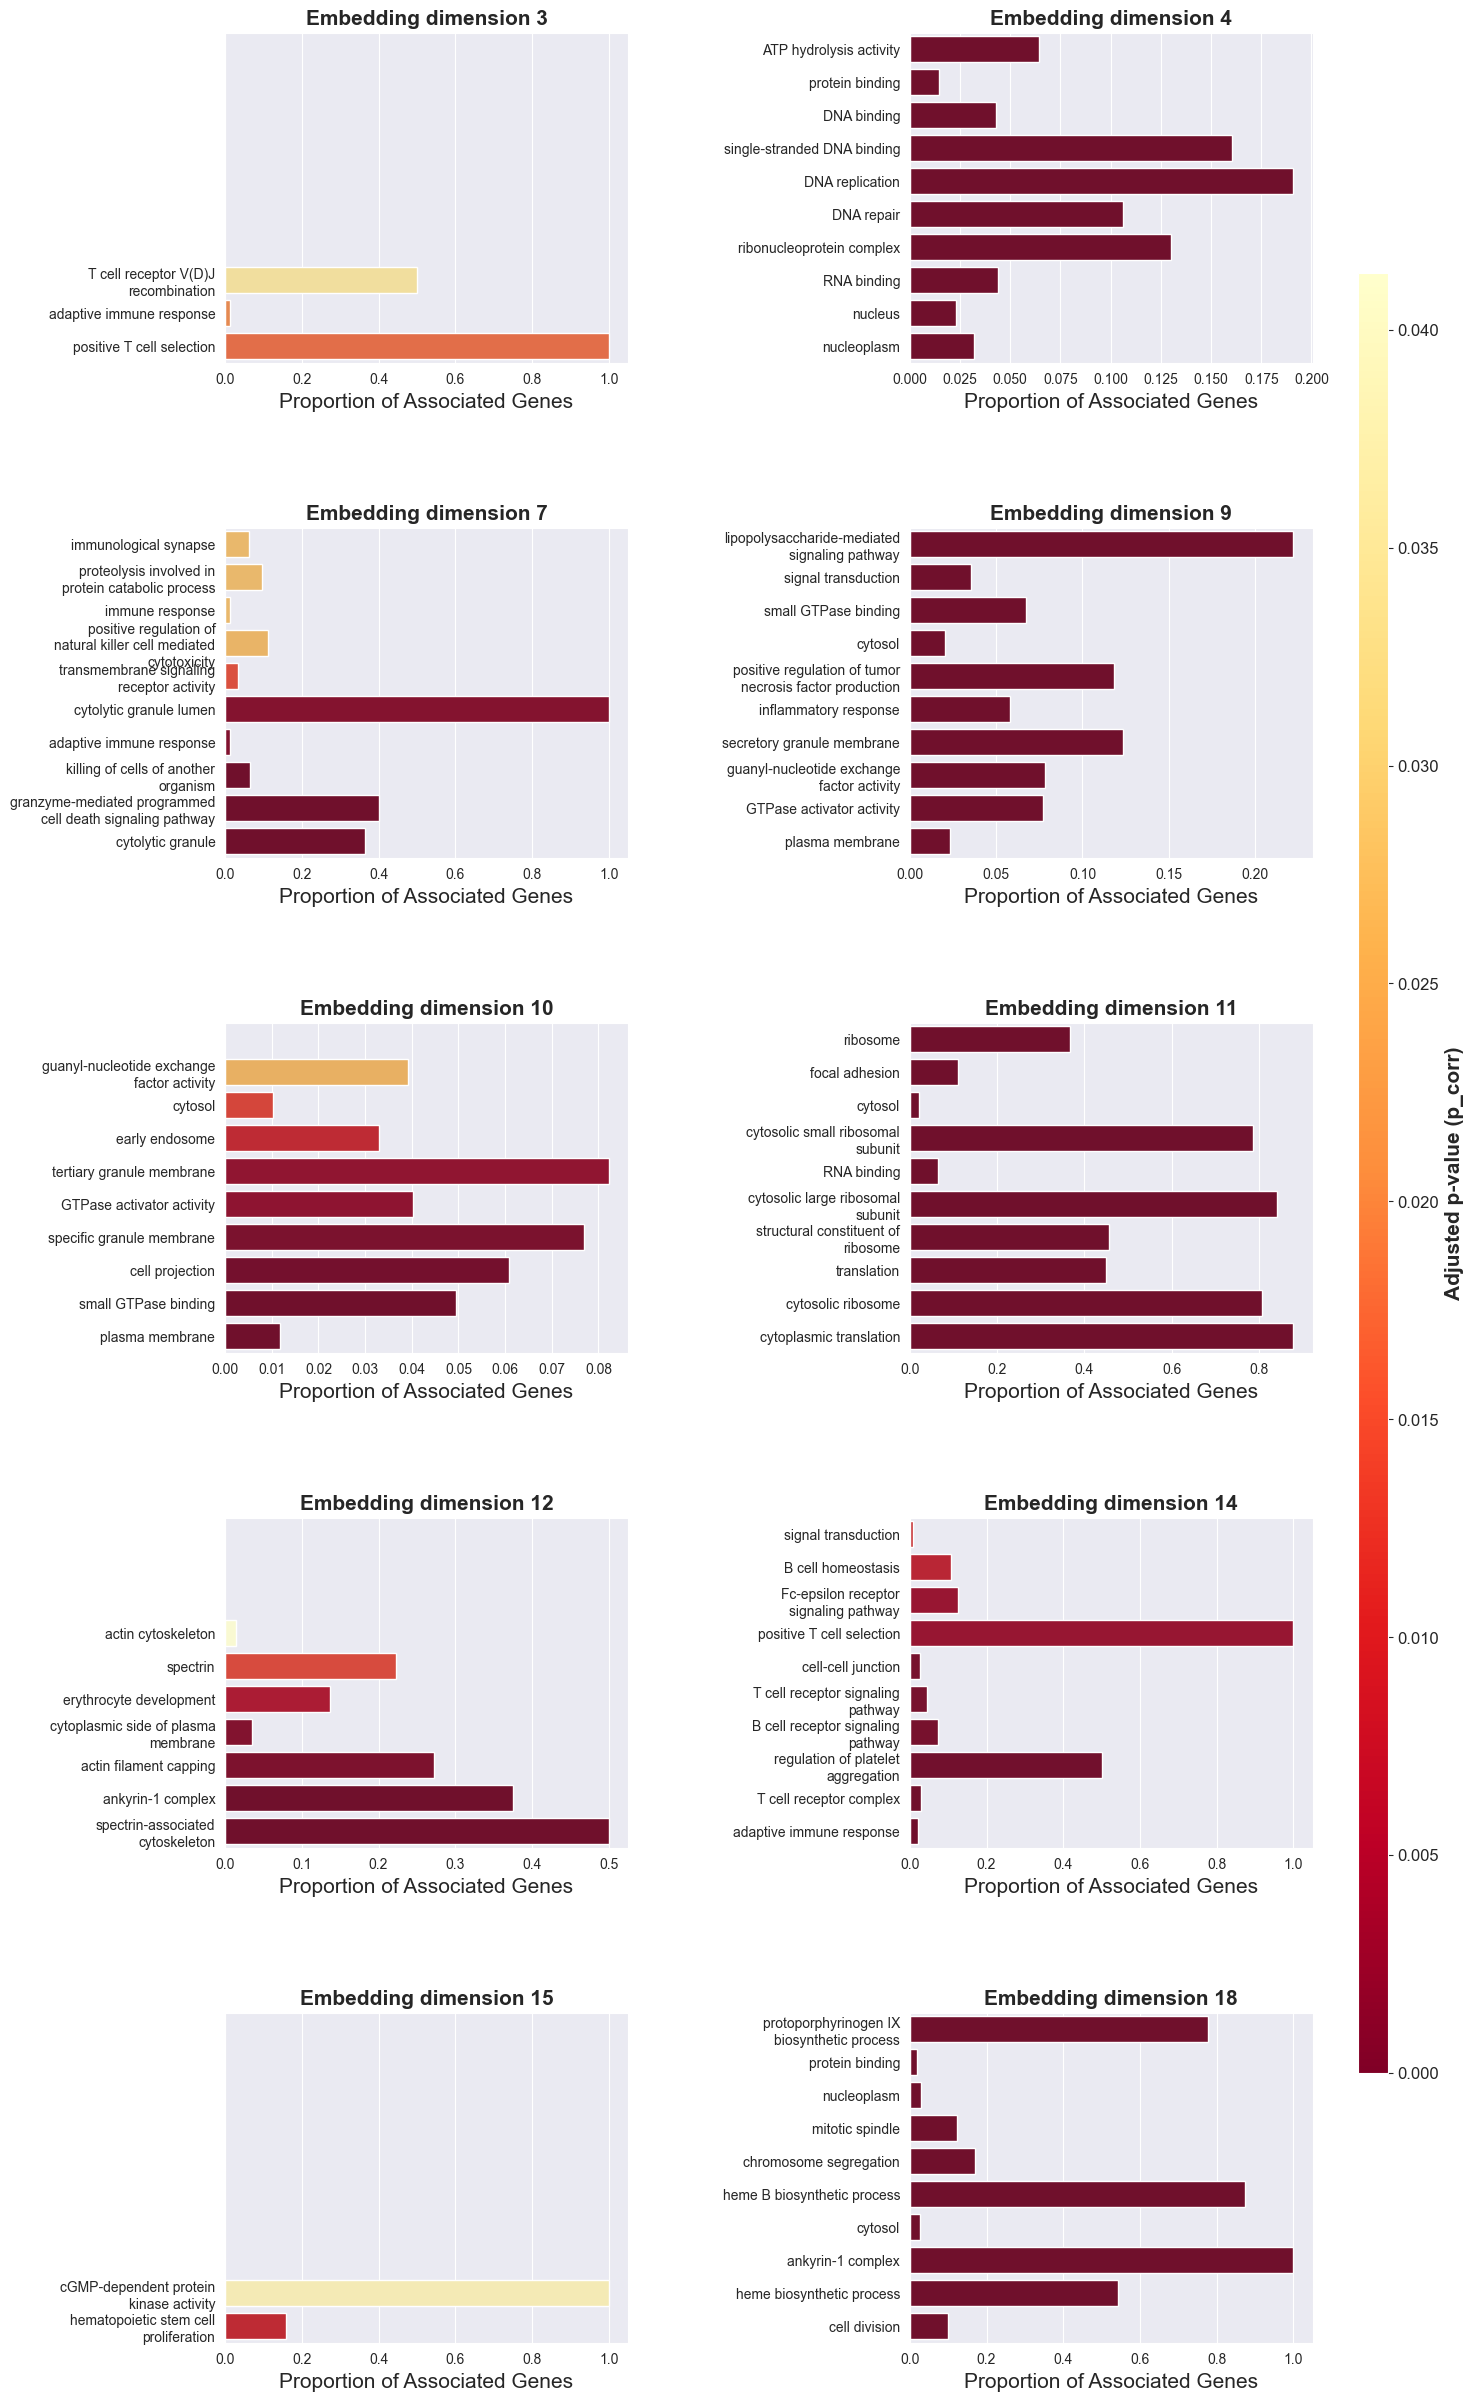

In [21]:
# Find max number of terms across all dimensions (for consistent bar height)
max_terms = max(len(go_results[dim]) for dim in filtered_dims)

# Set up figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
axes = axes.flatten()  # Flatten for easy indexing

# Define color normalization based on overall p_corr range
vmin = min(go_results[dim]['p_corr'].min() for dim in filtered_dims)
vmax = max(go_results[dim]['p_corr'].max() for dim in filtered_dims)
cmap = mpl.cm.YlOrRd_r 
norm = Normalize(vmin=vmin, vmax=vmax)

for i, dim in enumerate(filtered_dims):
    ax = axes[i]
    data = go_results[dim]
    # Convert p_corr values to hex colors
    colors = [to_hex(cmap(norm(p))) for p in data['p_corr']]
    # Plot
    sns.barplot(
        data=data, 
        x='per', 
        y='term', 
        ax=ax, 
        palette=colors,
        hue='p_corr',
        legend=False
    )
    ax.set_title(f"Embedding dimension {dim +1}", fontsize=15, fontweight='bold')
    ax.set_xlabel("Proportion of Associated Genes", fontsize=15)
    # Remove y-axis label (GO Term)
    ax.set_ylabel("")
    
    # Wrap long GO term names for readability
    ax.set_yticklabels([textwrap.fill(term, 28) for term in data['term']], fontsize=10)
    # Force consistent bar height
    ax.set_ylim(-0.5, max_terms - 0.5)  

# Adjust layout to prevent text overlap
fig.subplots_adjust(right=0.85, hspace=0.5, wspace=0.7)  

# Add colorbar to the right
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set empty array to make sure colorbar works
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.6])  # Adjust position to avoid overlap

# Create colorbar
cbar = fig.colorbar(sm, cax=cbar_ax)

# Increase label and tick font sizes
cbar.set_label("Adjusted p-value (p_corr)", fontsize=15, fontweight="bold")  # Bigger label
cbar.ax.tick_params(labelsize=12)  # Bigger tick labels

plt.savefig("GO_Enrichment_Plot_v.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# Highlight influence of single embedding dimensions in embedding space

import scanpy as sc
import umap

adata = sc.read_h5ad("/Users/olyssa/PycharmProjects/VAE_embeddings/PBMC_adata.h5ad")

# Define embedding space
embedding_data = adata.obsm["embedding"]

# Apply UMAP to reduce to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embedding_data)

df = pd.DataFrame({
    "UMAP_1": embeddings_2d[:, 0],
    "UMAP_2": embeddings_2d[:, 1]
})

/Users/olyssa/opt/anaconda3/envs/vae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/olyssa/opt/anaconda3/envs/vae/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


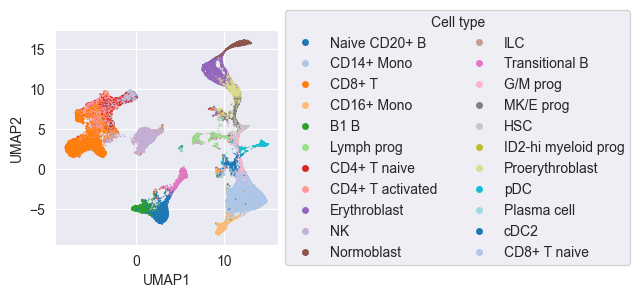

In [18]:
# Plot UMAP colored by cell types

categories_cell_type = adata.obs["cell type"].tolist()

fig, ax = plt.subplots(figsize=(6.5, 3))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue=categories_cell_type, palette="tab20", s=1, linewidth=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=5, title="Cell type", ncol=2)
fig.tight_layout()
fig.savefig('UMAP_cell_types.png', dpi=200)
plt.show()

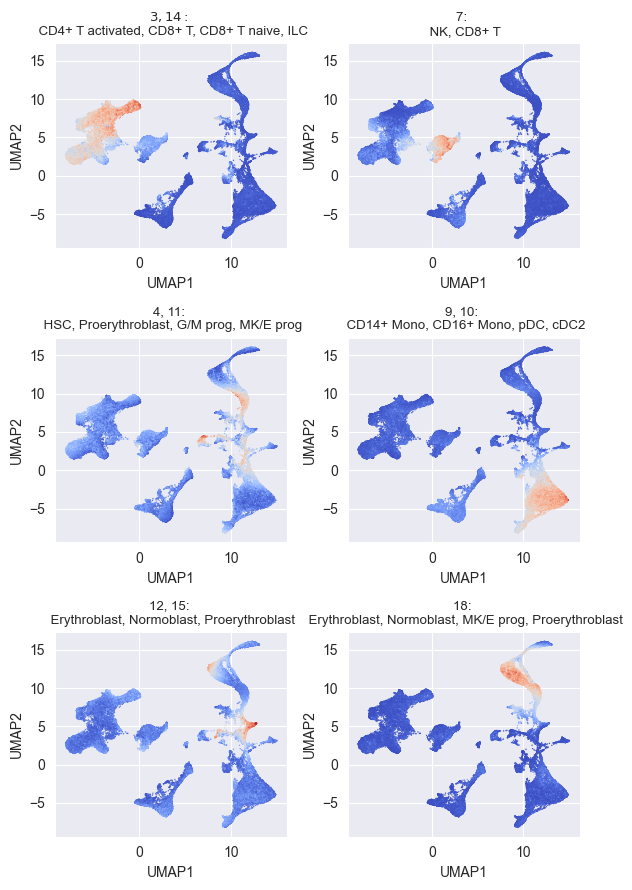

In [19]:
# Plot UMAP colored by dim

fontsize = 9.5

fig, ax = plt.subplots(3, 2, figsize=(6, 9))
ax[0,0].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 3-1]+embedding_data[:, 14-1], cmap="coolwarm", s=1, linewidth=0)
ax[0,0].set_title("$3, 14:$ \n CD4+ T activated, CD8+ T, CD8+ T naive, ILC", fontsize=fontsize) 
ax[0,1].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 7-1], cmap="coolwarm", s=1, linewidth=0)
ax[0,1].set_title(f"7: \n NK, CD8+ T", fontsize=fontsize) 
ax[1,0].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 4-1]+embedding_data[:, 11-1], cmap="coolwarm", s=1, linewidth=0)
ax[1,0].set_title(f"4, 11: \n HSC, Proerythroblast, G/M prog, MK/E prog", fontsize=fontsize) 
ax[1,1].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 9-1]+embedding_data[:, 10-1], cmap="coolwarm", s=1, linewidth=0)
ax[1,1].set_title(f"9, 10: \n CD14+ Mono, CD16+ Mono, pDC, cDC2", fontsize=fontsize) 
ax[2,0].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 12-1]+embedding_data[:, 15-1], cmap="coolwarm", s=1, linewidth=0)
ax[2,0].set_title(f"12, 15: \n Erythroblast, Normoblast, Proerythroblast", fontsize=fontsize) 
ax[2,1].scatter(df["UMAP_1"], df["UMAP_2"], c=embedding_data[:, 18-1], cmap="coolwarm", s=1, linewidth=0)
ax[2,1].set_title(f"18: \n Erythroblast, Normoblast, MK/E prog, Proerythroblast", fontsize=fontsize) 

for i in range(3):
    for k in range(2):
        ax[i, k].set_xlabel("UMAP1")
        ax[i, k].set_ylabel("UMAP2")

fig.tight_layout()
fig.savefig(f'UMAP_dimensions.png', dpi=200)
plt.show()